<a href="https://colab.research.google.com/github/Kamilr616/Emotion_sentiment_analysis/blob/develop/source/colab/Emotion_Sentiment_Analysis_tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies

Install necessary Python libraries for the project.


In [ ]:
!pip install tensorflow pandas scikit-learn kaggle seaborn nltk numpy


# Import libraries

Import all required libraries for data processing, model building, and evaluation.


In [ ]:
import pandas as pd
import tensorflow as tf
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import numpy as np

print("Tensorflow version = " + tf.__version__)

Tensorflow version = 2.15.0


# Upload configuration files

Upload necessary configuration files such as `kaggle.json` for accessing Kaggle datasets.


In [ ]:
os.makedirs('datasets', exist_ok=True)
files.upload()

Saving datasets.txt to datasets.txt
Saving datasets_source.txt to datasets_source.txt
Saving kaggle.json to kaggle.json


{'datasets.txt': b'#tweet_emotions.csv\r\nEmotion_classify_Data.csv\r\nemotion_sentimen_dataset.csv\r\ntext.csv\r\n',
 'datasets_source.txt': b'simaanjali/emotion-analysis-based-on-text\r\nshreejitcheela/text-emotion-recognition\r\npashupatigupta/emotion-detection-from-text\r\nnelgiriyewithana/emotions\r\nabdallahwagih/emotion-dataset\r\n',
 'kaggle.json': b'{"username":"kamilrataj","key":"c4a9a70b3990f45a4bf249bfe5bada5a"}'}

# Initialize Kaggle API

Set up the Kaggle API by configuring authentication.


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

import kaggle

# Fetch datasets from Kaggle

Define a function to download datasets from Kaggle using the provided configuration.


In [ ]:
def download_kaggle_datasets(dataset_list: str='datasets_source.txt') -> None:
    """
    Download each dataset specified in the list from Kaggle using the Kaggle API.
    Skips blank lines in file.

    Args:
    dataset_list (str): Path to a file containing a list of dataset identifiers on Kaggle.
    """
    try:
        with open(dataset_list, 'r') as file:
            for line in file:
                line = line.strip()
                if line:
                    try:
                        kaggle.api.dataset_download_files(line, path='datasets/', unzip=True)
                        print(f"Successfully downloaded {line}")
                    except Exception as e:
                        print(f"Failed to load {line}: {e}")
    except FileNotFoundError:
        print(f"File {dataset_list} not found.")
    except Exception as e:
        print(f"An error occurred while reading {dataset_list}: {e}")


download_kaggle_datasets('datasets_source.txt')

Dataset URL: https://www.kaggle.com/datasets/simaanjali/emotion-analysis-based-on-text
Successfully downloaded simaanjali/emotion-analysis-based-on-text
Dataset URL: https://www.kaggle.com/datasets/shreejitcheela/text-emotion-recognition
Successfully downloaded shreejitcheela/text-emotion-recognition
Dataset URL: https://www.kaggle.com/datasets/pashupatigupta/emotion-detection-from-text
Successfully downloaded pashupatigupta/emotion-detection-from-text
Dataset URL: https://www.kaggle.com/datasets/nelgiriyewithana/emotions
Successfully downloaded nelgiriyewithana/emotions
Dataset URL: https://www.kaggle.com/datasets/abdallahwagih/emotion-dataset
Successfully downloaded abdallahwagih/emotion-dataset


#Fetch Stopwords

In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load and preprocess datasets

Load the downloaded datasets and perform initial preprocessing.




In [ ]:
def load_datasets_from_file(filename: str='datasets.txt') -> list[pd.DataFrame]:
    """
    Reads filenames from a text file, each pointing to a dataset.
    Each dataset is loaded into a pandas DataFrame and all DataFrames
    are returned in a list. Skips blank lines and begining with '#'.

    Args:
    filename (str): The path to the text file containing dataset paths.

    Returns:
    list of pd.DataFrame: A list containing all the DataFrames loaded.
    """
    dataframes = []
    try:
        with open(filename, 'r') as file:
            for line in file:
                line = line.strip()
                if line:  # Ensures that blank lines are skipped
                  if line[0] == '#':
                    continue
                  else:
                      try:
                          # Load the dataset into a DataFrame
                          line = f"datasets/{line}"
                          dframe = pd.read_csv(line)
                          dataframes.append(dframe)
                      except Exception as e:
                          print(f"Failed to load {line}: {e}")
    except FileNotFoundError:
        print(f"File {filename} not found.")
    except Exception as e:
        print(f"An error occurred while reading {filename}: {e}")

    return dataframes


df_loaded_list = load_datasets_from_file('datasets.txt')
df_loaded_list

[                                                Comment Emotion
 0     i seriously hate one subject to death but now ...    fear
 1                    im so full of life i feel appalled   anger
 2     i sit here to write i start to dig out my feel...    fear
 3     ive been really angry with r and i feel like a...     joy
 4     i feel suspicious if there is no one outside l...    fear
 ...                                                 ...     ...
 5932                 i begun to feel distressed for you    fear
 5933  i left feeling annoyed and angry thinking that...   anger
 5934  i were to ever get married i d have everything...     joy
 5935  i feel reluctant in applying there because i w...    fear
 5936  i just wanted to apologize to you because i fe...   anger
 
 [5937 rows x 2 columns],
         Unnamed: 0                                               text  Emotion
 0                0  i seriously hate one subject to death but now ...     hate
 1                1             

# Standardize column names

In [ ]:
def standardize_column_names(frame: pd.DataFrame, column_map: dict) -> list[pd.DataFrame]:
    frame.columns = map(str.lower, frame.columns)

    reverse_mapping = {synonym: standard for standard, synonyms in column_map.items() for synonym in synonyms}

    for old_name, new_name in reverse_mapping.items():
        if old_name in frame.columns:
            frame.rename(columns={old_name: new_name}, inplace=True)

    return frame

column_mapping = {
    'text': ['text', 'content', "comment"],
    'emotion': ['emotion', 'label', 'sentiment']
}


df_std_list = []

for _df in df_loaded_list:
  df_std_list.append(standardize_column_names(_df, column_mapping))

df_std_list

[                                                   text emotion
 0     i seriously hate one subject to death but now ...    fear
 1                    im so full of life i feel appalled   anger
 2     i sit here to write i start to dig out my feel...    fear
 3     ive been really angry with r and i feel like a...     joy
 4     i feel suspicious if there is no one outside l...    fear
 ...                                                 ...     ...
 5932                 i begun to feel distressed for you    fear
 5933  i left feeling annoyed and angry thinking that...   anger
 5934  i were to ever get married i d have everything...     joy
 5935  i feel reluctant in applying there because i w...    fear
 5936  i just wanted to apologize to you because i fe...   anger
 
 [5937 rows x 2 columns],
         unnamed: 0                                               text  emotion
 0                0  i seriously hate one subject to death but now ...     hate
 1                1             

#Standardize labels

In [ ]:
def standardize_emotion_names(dataframe: pd.DataFrame, emotion_dict: dict) -> pd.DataFrame:
    """
    Standardize the names of emotions in a DataFrame.

    Args:
    dataframe (pd.DataFrame): The DataFrame containing emotion labels.
    emotion_dict (dict): A dictionary mapping original emotion names to standardized names.

    Returns:
    pd.DataFrame: The DataFrame with standardized emotion names.
    """
    reverse_emotion_dict = {synonym: emotion for emotion, synonyms in emotion_dict.items() for synonym in synonyms}
    dataframe['emotion'] = dataframe['emotion'].replace(reverse_emotion_dict)

    return dataframe


emotions_dictionary = {
    'sadness': ['sad', 'sadness', 'depressed', 0],
    'happiness': ['happy', 'happiness', 'joy', 1],
    'neutral': ['neutral', 'indifferent', 'unbiased'],
    'worry': ['worry', 'anxiety', 'concern'],
    'surprise': ['surprise', 'astonishment', 'shock', 5],
    'love': ['love', 'affection', 'adoration', 2],
    'anger': ['angry', 'rage', 'outrage', 'anger', 3],
    'relief': ['relief', 'ease', 'comfort'],
    'fear': ['fear', 'dread', 'terror', 4],
    'empty': ['empty', 'void', 'hollow'],
    'fun': ['fun', 'joyful', 'amusing'],
    'hate': ['hate', 'detest', 'loathe'],
    'enthusiasm': ['enthusiastic', 'excited', 'eager'],
    'boredom': ['boredom', 'tedium', 'monotony']
}

df_std_list_2 = []

for _df in df_std_list:
  df_std_list_2.append(standardize_emotion_names(_df, emotions_dictionary))

df_std_list_2


[                                                   text    emotion
 0     i seriously hate one subject to death but now ...       fear
 1                    im so full of life i feel appalled      anger
 2     i sit here to write i start to dig out my feel...       fear
 3     ive been really angry with r and i feel like a...  happiness
 4     i feel suspicious if there is no one outside l...       fear
 ...                                                 ...        ...
 5932                 i begun to feel distressed for you       fear
 5933  i left feeling annoyed and angry thinking that...      anger
 5934  i were to ever get married i d have everything...  happiness
 5935  i feel reluctant in applying there because i w...       fear
 5936  i just wanted to apologize to you because i fe...      anger
 
 [5937 rows x 2 columns],
         unnamed: 0                                               text  emotion
 0                0  i seriously hate one subject to death but now ...     h

#Check and drop NULL records

In [ ]:
df_std_list_3 = []

for _df in df_std_list_2:
  df_std_list_3.append(_df.dropna())
  print(_df.isnull().any())

text       False
emotion    False
dtype: bool
unnamed: 0    False
text          False
emotion       False
dtype: bool
unnamed: 0    False
text          False
emotion       False
dtype: bool


#Cleaning records

In [ ]:
def clean_text(text: str) -> str:
    """
    Preprocess the text data by removing user mentions, links
    and unnecessary characters.

    Args:
    text (str): The text to preprocess.

    Returns:
    str: The preprocessed text.
    """

    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'[^A-Za-z0-9\s]+', '', text)

    return text


df_clean_list = []

for _df in df_std_list_3:
  _df['text'] = _df['text'].apply(clean_text)
  df_clean_list.append(_df)

df_clean_list

[                                                   text    emotion
 0     i seriously hate one subject to death but now ...       fear
 1                    im so full of life i feel appalled      anger
 2     i sit here to write i start to dig out my feel...       fear
 3     ive been really angry with r and i feel like a...  happiness
 4     i feel suspicious if there is no one outside l...       fear
 ...                                                 ...        ...
 5932                 i begun to feel distressed for you       fear
 5933  i left feeling annoyed and angry thinking that...      anger
 5934  i were to ever get married i d have everything...  happiness
 5935  i feel reluctant in applying there because i w...       fear
 5936  i just wanted to apologize to you because i fe...      anger
 
 [5937 rows x 2 columns],
         unnamed: 0                                               text  emotion
 0                0  i seriously hate one subject to death but now ...     h

# Chat words mapping

This function replaces specific words in a given text with their corresponding values from a predefined dictionary, chat_words.

In [ ]:
def replace_chat_words(text: str) -> str:
    """
    Replace specific words in the input text with their corresponding values from the chat_words dictionary.

    Args:
    text (str): The input text containing words to be replaced.

    Returns:
    str: The text with words replaced according to the chat_words dictionary.
    """

    words = text.split()
    for i, word in enumerate(words):
        if word.lower() in chat_words:
            words[i] = chat_words[word.lower()]
    return ' '.join(words)


chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

df_clean_list_2 = []

for _df in df_clean_list:
  _df['text'] = _df['text'].apply(replace_chat_words)
  df_clean_list_2.append(_df)

df_clean_list_2


[                                                   text    emotion
 0     i seriously hate one subject to death but now ...       fear
 1                    im so full of life i feel appalled      anger
 2     i sit here to write i start to dig out my feel...       fear
 3     ive been really angry with r and i feel like a...  happiness
 4     i feel suspicious if there is no one outside l...       fear
 ...                                                 ...        ...
 5932                 i begun to feel distressed for you       fear
 5933  i left feeling annoyed and angry thinking that...      anger
 5934  i were to ever get married i d have everything...  happiness
 5935  i feel reluctant in applying there because i w...       fear
 5936  i just wanted to apologize to you because i fe...      anger
 
 [5937 rows x 2 columns],
         unnamed: 0                                               text  emotion
 0                0  i seriously hate one subject to death but now ...     h

# Stopwords

In [ ]:
def remove_stop_words_from_dfs(df_list: list[pd.DataFrame], stop_words) -> list[pd.DataFrame]:
    """
    Process a list of dataframes by removing stop words from the 'text' column of each dataframe.

    Args:
    df_list (list of pd.DataFrame): A list of pandas dataframes, each containing a 'text' column with strings to be cleaned.
    stop_words (set or list of str): A set or list of stop words to be removed from the text.

    Returns:
    list of pd.DataFrame: A list of pandas dataframes with stop words removed from the 'text' column.
    """

    df_words_list = []

    for _df in df_list:
        _df["text"] = _df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
        df_words_list.append(_df)

    return df_words_list


df_words_list = remove_stop_words_from_dfs(df_clean_list_2, stop_words)

df_words_list

[                                                   text    emotion
 0     seriously hate one subject death feel reluctan...       fear
 1                            im full life feel appalled      anger
 2     sit write start dig feelings think afraid acce...       fear
 3     ive really angry r feel like idiot trusting fi...  happiness
 4     feel suspicious one outside like rapture happe...       fear
 ...                                                 ...        ...
 5932                              begun feel distressed       fear
 5933  left feeling annoyed angry thinking center stu...      anger
 5934  ever get married everything ready offer got to...  happiness
 5935  feel reluctant applying want able find company...       fear
 5936         wanted apologize feel like heartless bitch      anger
 
 [5937 rows x 2 columns],
         unnamed: 0                                               text  emotion
 0                0  seriously hate one subject death feel reluctan...     h

#Stemming (whitespace)

This function processes a list of dataframes by normalizing whitespace in the 'text' column of each dataframe. Specifically, it replaces multiple consecutive spaces with a single space. This ensures that the text data is uniformly formatted and free of irregular spacing.

In [ ]:
def normalize_whitespace_in_dfs(df_list: list[pd.DataFrame]) -> list[pd.DataFrame]:
    """
    Process a list of dataframes by normalizing whitespace in the 'text' column of each dataframe.

    Args:
    df_list (list of pd.DataFrame): A list of pandas dataframes, each containing a 'text' column with strings to be cleaned.

    Returns:
    list of pd.DataFrame: A list of pandas dataframes with normalized whitespace in the 'text' column.
    """

    df_stemmed_list = []

    for _df in df_list:
        _df['text'] = _df['text'].str.replace(r'\s+', ' ', regex=True)
        df_stemmed_list.append(_df)

    return df_stemmed_list


df_stemmed_list = normalize_whitespace_in_dfs(df_clean_list)

df_stemmed_list

[                                                   text    emotion
 0     seriously hate one subject death feel reluctan...       fear
 1                            im full life feel appalled      anger
 2     sit write start dig feelings think afraid acce...       fear
 3     ive really angry r feel like idiot trusting fi...  happiness
 4     feel suspicious one outside like rapture happe...       fear
 ...                                                 ...        ...
 5932                              begun feel distressed       fear
 5933  left feeling annoyed angry thinking center stu...      anger
 5934  ever get married everything ready offer got to...  happiness
 5935  feel reluctant applying want able find company...       fear
 5936         wanted apologize feel like heartless bitch      anger
 
 [5937 rows x 2 columns],
         unnamed: 0                                               text  emotion
 0                0  seriously hate one subject death feel reluctan...     h

# Merge dataframes

In [ ]:
def concat_dataframes(dataframes: list[pd.DataFrame]) -> pd.DataFrame:
    """
    Concatenate a list of DataFrames into a single DataFrame.

    Args:
    dataframes (list of pd.DataFrame): A list of DataFrames to concatenate.

    Returns:
    pd.DataFrame: A single DataFrame containing all the data from the input DataFrames.
    """

    final_dataset = []

    for df in dataframes:
        final_dataset.append(df[['text', 'emotion']])

    return pd.concat(final_dataset, ignore_index=True)


df_merged = concat_dataframes(df_stemmed_list)
df_merged

,text,emotion
0,seriously hate one subject death feel reluctan...,fear
1,im full life feel appalled,anger
2,sit write start dig feelings think afraid acce...,fear
3,ive really angry r feel like idiot trusting fi...,happiness
4,feel suspicious one outside like rapture happe...,fear
...,...,...
1262296,feel like telling horny devils find site suite...,love
1262297,began realize feeling agitated restless would ...,anger
1262298,feel curious previous early dawn time seek tro...,surprise
1262299,feel becuase tyranical nature government el sa...,anger


# Drop duplicates

This function removes duplicate rows from a dataframe based on the 'text' column and returns the dataframe with unique records. Additionally, it calculates and prints the number of unique records.

In [ ]:
def remove_duplicates_and_count(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove duplicate rows from the dataframe based on the 'text' column and count the number of unique records.

    Args:
    df (pd.DataFrame): The input dataframe containing a 'text' column with strings.

    Returns:
    pd.DataFrame: The dataframe with duplicate rows removed based on the 'text' column.
    """
    df_unique = df.drop_duplicates(subset=['text'])

    return df_unique


df_unique = remove_duplicates_and_count(df_merged)

print(f'Number of unique records: {len(df_unique)}')
df_unique

Number of unique records: 382153


,text,emotion
0,seriously hate one subject death feel reluctan...,fear
1,im full life feel appalled,anger
2,sit write start dig feelings think afraid acce...,fear
3,ive really angry r feel like idiot trusting fi...,happiness
4,feel suspicious one outside like rapture happe...,fear
...,...,...
428677,cry feel sense loss patients die helped die di...,neutral
428678,feel like telling horny devils find site suite...,neutral
428680,feel curious previous early dawn time seek tro...,neutral
428681,feel becuase tyranical nature government el sa...,neutral


# Drop unnessesary columns

In [ ]:
df_unique = df_unique[['text', 'emotion']]
df_unique.shape

(382153, 2)

#Shuffling records

In [ ]:
df_shuffled = df_unique.sample(frac=1).reset_index(drop=True)
df_shuffled

,text,emotion
0,im size one feeling generous buy href http www,neutral
1,feel like treating friends family something sweet,neutral
2,feel tranquil soothes pain,neutral
3,feel privileged shared event everyone highly r...,love
4,cannot feel dahl would hated,hate
...,...,...
382148,need remember stretch feel fine,neutral
382149,feeling extremely agitated upcoming appointments,neutral
382150,feel lonely times times still feel alone,neutral
382151,woke feeling like body hated sure garage dumpe...,hate


# Describe and check dataset

In [ ]:
df_shuffled.describe()

,text,emotion
count,382153,382153
unique,382153,14
top,cuted feel pain class aimg libtitle target bla...,neutral
freq,1,301536


#Visualize content

In [ ]:
df_shuffled['emotion'].value_counts()

emotion
neutral       301536
love           17291
happiness      14641
sadness         8248
relief          7735
anger           7716
hate            5911
fun             4704
enthusiasm      4366
surprise        3371
empty           2622
worry           2027
fear            1924
boredom           61
Name: count, dtype: int64

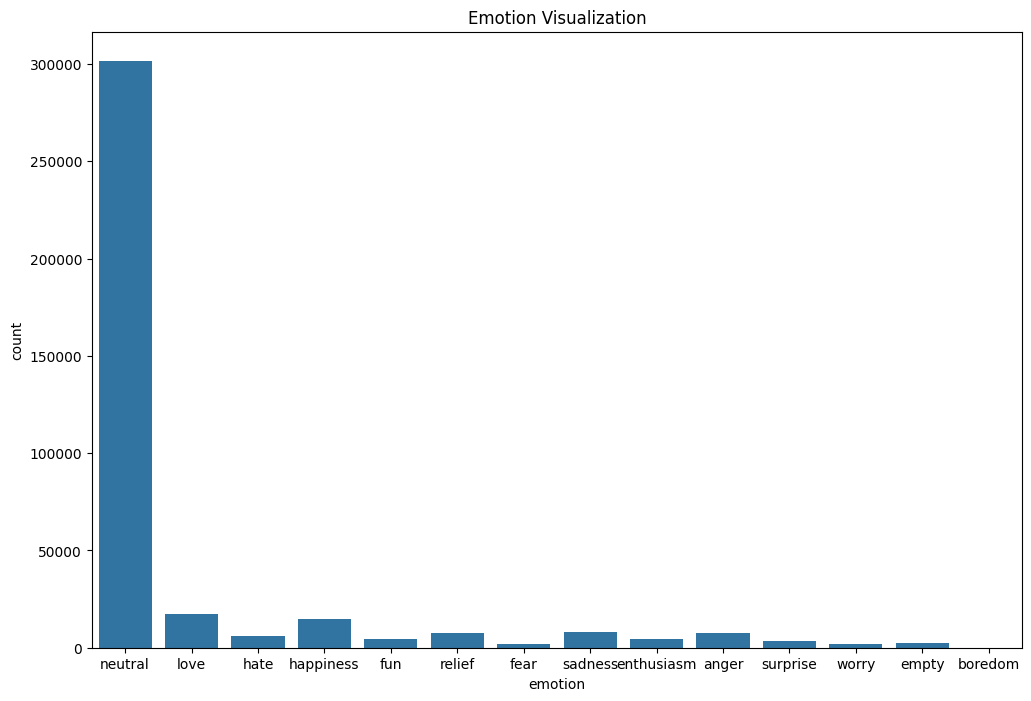

In [ ]:
plt.figure(figsize=(12, 8))
sns.countplot(x='emotion', data=df_shuffled)
plt.title('Emotion Visualization')
plt.show()

#Label Encoding

In [ ]:
texts = df_shuffled['text'].values
labels = df_shuffled['emotion'].values

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_encoded = to_categorical(labels_encoded)

labels

labels_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

#Tokenization

In [ ]:
tokenizer = Tokenizer(num_words=60000, lower=True)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=100)

# Traning Test Split

Split the dataset into training and testing sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels_encoded, test_size=0.2, random_state=42)

# Build the model

Construct the neural network model using Keras.


In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=100))
model.add(SpatialDropout1D(0.2))

model.add(Bidirectional(LSTM(128)))

model.add(BatchNormalization())

model.add(Dropout(0.5))

model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          7513800   
                                                                 
 spatial_dropout1d (Spatial  (None, 100, 100)          0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 256)               234496    
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

# Train and evaluate model

Train the model on the training data and evaluate its performance on the testing data.

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=2)

loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Loss: {loss * 100:.2f}%')

Epoch 1/10
4180/4180 - 104s - loss: 0.2120 - accuracy: 0.9602 - val_loss: 0.1563 - val_accuracy: 0.9672 - 104s/epoch - 25ms/step
Epoch 2/10
4180/4180 - 67s - loss: 0.0992 - accuracy: 0.9816 - val_loss: 0.1062 - val_accuracy: 0.9828 - 67s/epoch - 16ms/step
Epoch 3/10
4180/4180 - 65s - loss: 0.0783 - accuracy: 0.9836 - val_loss: 0.1089 - val_accuracy: 0.9826 - 65s/epoch - 16ms/step
Epoch 4/10
4180/4180 - 66s - loss: 0.0663 - accuracy: 0.9851 - val_loss: 0.1158 - val_accuracy: 0.9827 - 66s/epoch - 16ms/step
Epoch 5/10
4180/4180 - 66s - loss: 0.0569 - accuracy: 0.9866 - val_loss: 0.1199 - val_accuracy: 0.9809 - 66s/epoch - 16ms/step
Epoch 6/10
4180/4180 - 73s - loss: 0.0505 - accuracy: 0.9876 - val_loss: 0.1236 - val_accuracy: 0.9811 - 73s/epoch - 17ms/step
Epoch 7/10
4180/4180 - 69s - loss: 0.0451 - accuracy: 0.9888 - val_loss: 0.1334 - val_accuracy: 0.9795 - 69s/epoch - 16ms/step
Epoch 8/10
4180/4180 - 65s - loss: 0.0412 - accuracy: 0.9894 - val_loss: 0.1482 - val_accuracy: 0.9764 - 65s/

# Classification report

Generate a detailed classification report to assess the model's performance.

In [ ]:
# Predict classes
y_pred = model.predict(X_test)

# Convert predicted probabilities to class indices
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded true labels back to single labels
y_test_labels = np.argmax(y_test, axis=1)


print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

3583/3583 [==============================] - 46s 13ms/step
Classification Report:
              precision    recall  f1-score   support

       anger       0.87      0.75      0.80      2360
     boredom       1.00      1.00      1.00        15
       empty       0.99      0.99      0.99       807
  enthusiasm       0.98      1.00      0.99      1317
        fear       0.01      0.01      0.01       576
         fun       0.98      0.99      0.98      1393
   happiness       0.92      0.87      0.89      4459
        hate       0.97      0.99      0.98      1744
        love       0.99      0.99      0.99      5184
     neutral       0.98      0.99      0.99     90296
      relief       0.97      0.99      0.98      2339
     sadness       0.99      1.00      0.99      2504
    surprise       0.99      1.00      0.99      1036
       worry       0.98      0.99      0.98       616

    accuracy                           0.98    114646
   macro avg       0.90      0.90      0.90    11464

# Save model file

Save the trained model to a file for future use.

In [ ]:
model.save('emotion_classification_model.h5')
print("Model saved to emotion_classification_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to emotion_classification_model.h5


# Test model on input data

Evaluate the model on new input texts to predict their emotion categories.

In [ ]:
new_texts = ["The sun is shining and everything seems possible today! I am so uplifted!",
             "Excited to start my new job next week!",
             "Watching the sunset with my loved ones, life is good.",
             "The project deadline is approaching, and I haven't started."]


new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded_sequences = pad_sequences(new_sequences, maxlen=100)
predictions = model.predict(new_padded_sequences)

for i, prediction in enumerate(predictions):
    predicted_label = label_encoder.inverse_transform([prediction.argmax()])[0]
    print(f'Text: {new_texts[i]} - Predicted Emotion: {predicted_label}')

1/1 [==============================] - 0s 54ms/step
Text: The sun is shining and everything seems possible today! I am so excited! - Predicted Emotion: enthusiasm
Text: Excited to start my new job next week! - Predicted Emotion: enthusiasm
Text: Watching the sunset with my loved ones, life is good. - Predicted Emotion: love
Text: The project deadline is approaching, and I haven't started. - Predicted Emotion: neutral


63/63 [==============================] - 2s 37ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets